# Neural representation of drifting grating stimulus 

In [41]:
from scipy.spatial import distance as dist
from spikeship import spikeship
from spot import spot
import time
import numpy as np
import matplotlib 
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import itertools 
import argparse
import os 
import math
from mpl_toolkits.axes_grid1 import make_axes_locatable
from allensdk.brain_observatory.ecephys.ecephys_session import EcephysSession
from utils import dis_of_dis_transform

/home/jinkel/anaconda3/envs/spot/lib/python3.6/site-packages/sklearn/utils/deprecation.py:143: FutureWarning: The sklearn.datasets.samples_generator module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.datasets. Anything that cannot be imported from sklearn.datasets is now part of the private API.
  warnings.warn(message, FutureWarning)


In [38]:
def raster(spike_times,ii_spike_times,i_epoch = 0, filename = 'raster', color ='black'):
    '''
    plot the spikes for a given epoch_id
    default show the first epoch 
    '''
    f, ax = plt.subplots()

    # ax.set_title('Example pattern epoch raster plot')
    n_neurons = ii_spike_times.shape[1]
    for i_neuron in range(n_neurons):
        tmp_epoch_neuron_spike_times = spike_times[int(ii_spike_times[i_epoch, i_neuron, 0]):int(ii_spike_times[i_epoch, i_neuron, 1])]
        ax.scatter(tmp_epoch_neuron_spike_times, np.ones(len(tmp_epoch_neuron_spike_times))+i_neuron, marker='|', c=color)

    # ax.set_yticks(np.arange(0, n_neurons+1, 5))
    ax.set_ylabel('Neuron')
    ax.set_xlabel('Time')
    plt.savefig(filename)

# def cluster_spot(spike_times,ii_spike_times,epoch_labels):
#     '''
#     spotdisclust
#     '''
#     start_time = time.time()
#     dissimilarities = spot.distances(spike_times, ii_spike_times, metric='SPOTD_xcorr')
#     print('Spot took {} seconds'.format(time.time() - start_time))

#     plt.title('Sorted SPOTDis matrix');plt.imshow(dissimilarities, cmap='PuBu')
#     plt.colorbar().set_label('SPOTDis');plt.xlabel('Epoch');plt.ylabel('Epoch');plt.show()
#     embedded_distances = TSNE(n_components=2, metric='precomputed',random_state = 42).fit_transform(dissimilarities)
#     plt.scatter(embedded_distances[:, 0], embedded_distances[:, 1], c=epoch_labels ,marker='o',s = 5) 
#     plt.title('tsne visualization');plt.show()
#     return dissimilarities 


# def cluster_fspot(ii_spike_times, spike_times, epoch_index_pairs, epoch_labels, prefix):
#     '''
#     spikeship
#     '''
#     start_time = time.time()
#     dissimilarities, G = spikeship.distances_SpikeShip(ii_spike_times, spike_times, epoch_index_pairs)
#     print('Spikeship took {} seconds'.format(time.time() - start_time))
#     fig, ax = plt.subplots()
#     plt.title('Sorted fSPOTDis matrix')
#     plt.imshow(dissimilarities, cmap='PuBu')
#     plt.colorbar().set_label('fSPOTDis');plt.xlabel('Epoch');plt.ylabel('Epoch');fig.savefig(prefix+'fSPOTDis')
#     return dissimilarities 

### Read Allen Institute Neuropixel data as a NWB file

In [22]:
session_id = '754829445'
unit_snr = 0.5 # signal to noise ratio 
START = 0 # start time from onset of stimulus 
STOP = 0.1 # stop time from onset of stimulus 
data_path = '/mnt/pns/departmentN4/AllenVisualCoding/data'+'/session_'+str(session_id)+'/session_'+str(session_id)+'.nwb' # path to .nwb files 
# data_directory = '/mnt/pns/home/jinkel/Desktop/AllenNeuropixel/npx/{}'.format(session_id) # where .nwb files are
directory_out = '/mnt/pns/home/jinkel/Desktop/disofdis_tsne'

In [17]:
# read the data 
session = EcephysSession.from_nwb_path(data_path)
# select the visual units 
neuron_types = ['VISp','VISl','VISal','VISpm','VISrl','VISam'] # visual cortical areas 
neurons = session.units[session.units.ecephys_structure_acronym.isin(neuron_types)]
high_snr_units = neurons[neurons['snr'] > unit_snr] # select high snr units 
high_snr_units = high_snr_units.iloc[np.argsort(high_snr_units.ecephys_structure_acronym.values)] # sort units by area
n_neuron = high_snr_units.shape[0]
print('number of selected neurons: {}'.format(n_neuron))

number of selected neurons: 191


In [18]:
# select the trials 
stimulus_type = 'drifting_gratings'
presentations = session.stimulus_presentations[session.stimulus_presentations.stimulus_name==stimulus_type]
n_stim = presentations.shape[0]
print('number of selected trials: {}'.format(n_stim))
print('The average duration of {} stimulus is: {}'.format(stimulus_type,presentations.duration.values.mean()))

number of selected trials: 630
The average duration of drifting_gratings stimulus is: 2.001673000000015


In [35]:
# orientation abel for trial 
target_orientation = presentations['orientation'].values
target_orientation = [i if i!='null' else 359 for i in target_orientation] # 359 stands for missing label 
target_orientation = np.array(target_orientation)
target_orientation_color = ['b' if i == 0 
                            else 'r' if i == 45 
                            else 'g' if i == 90 
                            else 'purple' if i == 135
                            else 'c' if i == 180
                            else 'orange' if i == 225
                            else 'y' if i == 270
                            else 'pink' if i == 315
                            else 'k'
                            for i in target_orientation] # drift gratings 
target_orientation_color = np.array(target_orientation_color)

In [21]:
#%% convert stim response to spot data format 
stim_spike_times = np.array([])
stim_ii_spike_times = np.zeros([n_stim,n_neuron,2])

for i in range(n_stim):
    start_time_i = presentations.iloc[i].start_time + START
    stop_time_i = presentations.iloc[i].start_time + STOP
    for j in range(n_neuron):
        spike_time  = session.spike_times[high_snr_units.index[j]]
        spike_time = spike_time[(spike_time>start_time_i)&(spike_time<stop_time_i)]
        stim_spike_times = np.append(stim_spike_times,spike_time - start_time_i) # relative spike time to the start_time_i 
        stim_ii_spike_times[i,j,0] = int(np.max(stim_ii_spike_times))
        stim_ii_spike_times[i,j,1] = int(stim_ii_spike_times[i,j,0] + len(spike_time))
        
print('\n stim data-set dimensions\n')      
print('spike_times (#spikes): {}'.format(stim_spike_times.shape))
print('ii_spike_times (#epochs x #neurons x 2): {}\n'.format(stim_ii_spike_times.shape))

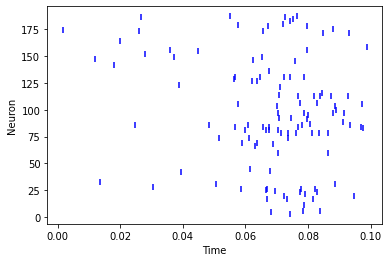

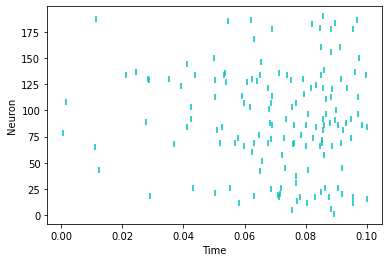

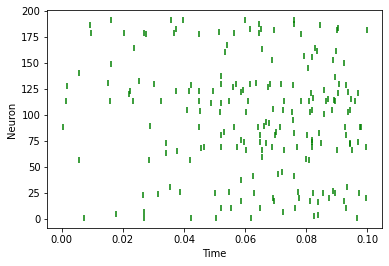

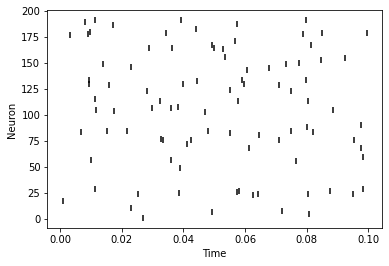

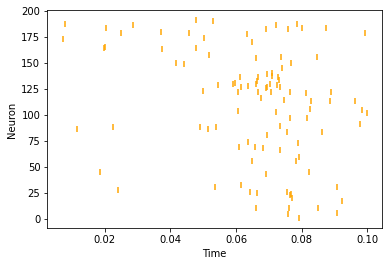

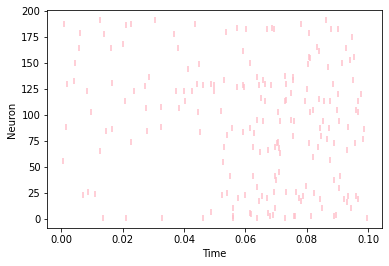

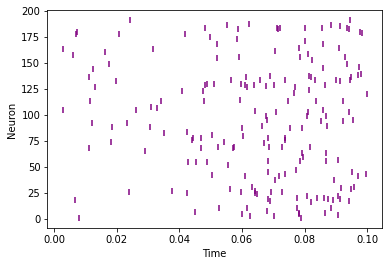

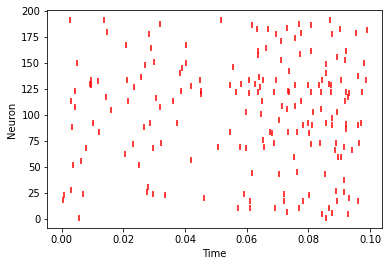

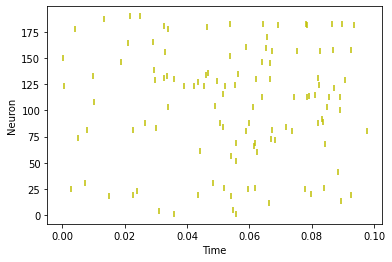

In [37]:
# example raster plot of each orientation response 
ori_dict = {'b': 0, 'r': 45, 'g':90, 'purple': 135, 'c':180, 'orange':225, 'y':270, 'pink':315, 'k':'na'}
for i in np.unique(target_orientation_color):
    i_epoch = np.where(target_orientation_color==i)[0][0]
    raster(stim_spike_times,stim_ii_spike_times, i_epoch, filename = os.path.join(directory_out,'raster_{}'.format(ori_dict[i])), color = i)

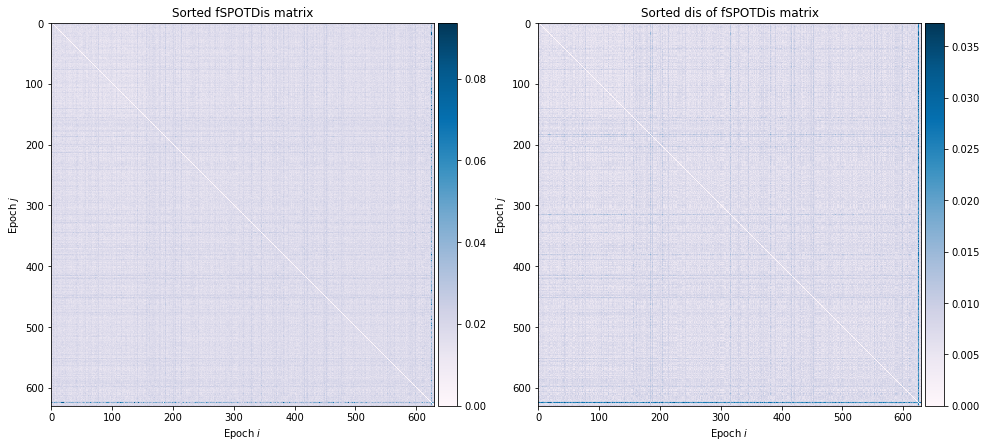

In [42]:
# spot distances between stimulus points 
epoch_index_pairs = np.array(list(itertools.combinations(range(n_stim), 2)),dtype=int)
dissimilarities, _ = spikeship.distances_SpikeShip(stim_ii_spike_times, stim_spike_times, epoch_index_pairs)
ddistances = dis_of_dis_transform(dissimilarities, n_neighbors=5)
# visualize the dissimilarity matrices 
fig, axa = plt.subplots(1,2, figsize=(16,8))
axa[0].set_title('Sorted fSPOTDis matrix');axa[0].set_xlabel('Epoch $\it{i}$');axa[0].set_ylabel('Epoch $\it{j}$')
im1 = axa[0].imshow(dissimilarities, cmap='PuBu', interpolation='nearest', aspect='equal');
axa[1].set_title('Sorted dis of fSPOTDis matrix');axa[1].set_xlabel('Epoch $\it{i}$');axa[1].set_ylabel('Epoch $\it{j}$')
im2 = axa[1].imshow(ddistances, cmap='PuBu', interpolation='nearest', aspect='equal');
plt.colorbar(im1,ax=axa[0],cax=make_axes_locatable(axa[0]).append_axes("right", size="5%", pad=0.05))
plt.colorbar(im2,ax=axa[1],cax=make_axes_locatable(axa[1]).append_axes("right", size="5%", pad=0.05))
plt.show()

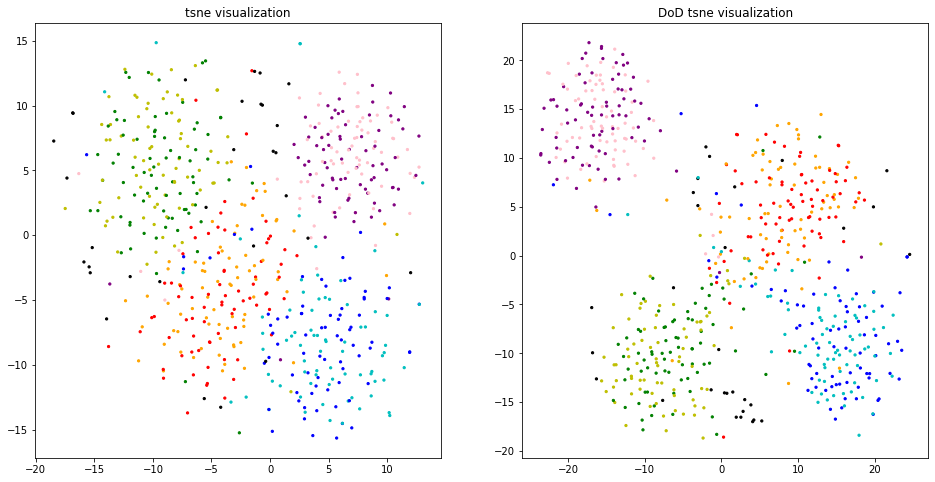

In [44]:
embedded_distances = TSNE(n_components=2, metric='precomputed',random_state = 42).fit_transform(dissimilarities)
dis_of_dis_embedded_distances = TSNE(n_components=2, metric='precomputed',random_state = 42).fit_transform(ddistances)
fig, ax = plt.subplots(1,2,figsize=(16,8))
ax[0].scatter(embedded_distances[:, 0], embedded_distances[:, 1], c=target_orientation_color ,marker='o',s = 5) 
ax[1].scatter(dis_of_dis_embedded_distances[:, 0], dis_of_dis_embedded_distances[:, 1], c=target_orientation_color,marker='o',s = 5) 
ax[0].set_title('tsne visualization')
ax[1].set_title('DoD tsne visualization')
plt.show()

We can see that the distance of distance transformation does not distort the orientation clustering patterns of the visual response

In [45]:
# convert spontaneous activities to spot data format 
spont_spike_times = np.array([])
spont_ii_spike_times = np.zeros([n_stim,n_neuron,2])

for i in range(n_stim):
    start_time_i = presentations.iloc[i].start_time - (STOP - START)
    stop_time_i = presentations.iloc[i].start_time
    for j in range(n_neuron):
        spike_time  = session.spike_times[high_snr_units.index[j]]
        spike_time = spike_time[(spike_time>start_time_i )&(spike_time<stop_time_i)]
        spont_spike_times = np.append(spont_spike_times,spike_time - start_time_i) # relative spike time to the start_time_i 
        spont_ii_spike_times[i,j,0] = int(np.max(spont_ii_spike_times))
        spont_ii_spike_times[i,j,1] = int(spont_ii_spike_times[i,j,0] + len(spike_time))
        
print('\n spont data-set dimensions\n')
print('spike_times (#spikes): {}'.format(spont_spike_times.shape))
print('ii_spike_times (#epochs x #neurons x 2): {}\n'.format(spont_ii_spike_times.shape))


 spont data-set dimensions

spike_times (#spikes): (56099,)
ii_spike_times (#epochs x #neurons x 2): (630, 191, 2)



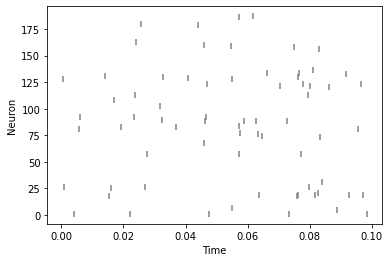

In [48]:
# raster plot of one example of spontaneous activities intertrial interval 
raster(spont_spike_times,spont_ii_spike_times, filename = os.path.join(directory_out,'raster_spont'), color ='grey')
n_spont = spont_ii_spike_times.shape[0]

In [49]:
# tSNE on all points
all_spike_times = np.append(stim_spike_times, spont_spike_times)
all_ii_spike_times = np.vstack((stim_ii_spike_times,spont_ii_spike_times))

epoch_index_pairs = np.array(list(itertools.combinations(range(n_stim+n_spont), 2)),dtype=int)
sim_distances, _ = spikeship.distances_SpikeShip(all_ii_spike_times, all_spike_times, epoch_index_pairs)
ddistances = dis_of_dis_transform(sim_distances, n_neighbors=50)

embedded_distances = TSNE(n_components=2, metric='precomputed',random_state = 42).fit_transform(sim_distances)
embedded_ddistances = TSNE(n_components=2, metric='precomputed',random_state = 42).fit_transform(ddistances)

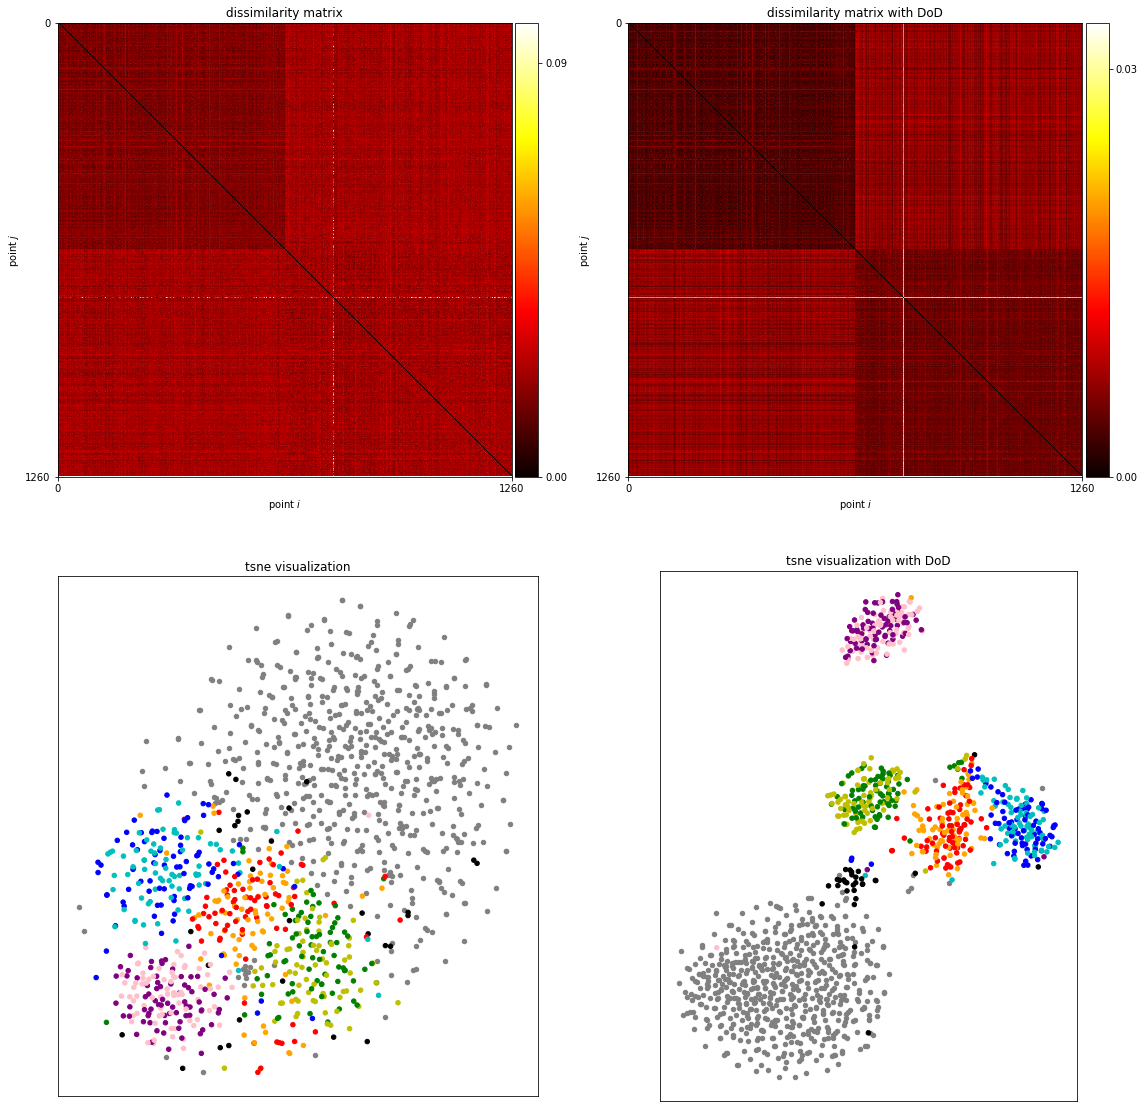

In [54]:
# plot

fig, axa = plt.subplots(2,2,figsize = (16,16))
# plot the representational dissimilarity matrices  

axa[0][0].set_title('dissimilarity matrix');
axa[0][0].set_xlabel('point $\it{i}$');axa[0][0].set_ylabel('point $\it{j}$')
im1 = axa[0][0].imshow(sim_distances, cmap='hot', interpolation='nearest', aspect='equal')
plt.colorbar(im1,ax=axa[0][0],ticks=[0,math.floor(np.max(sim_distances)*100)/100.0],cax=make_axes_locatable(axa[0][0]).append_axes("right", size="5%", pad=0.05))
axa[0][0].set_xticks([0, sim_distances.shape[0]]); axa[0][0].set_yticks([0, sim_distances.shape[0]])


axa[0][1].set_title('dissimilarity matrix with DoD');
axa[0][1].set_xlabel('point $\it{i}$');axa[0][1].set_ylabel('point $\it{j}$')
im2 = axa[0][1].imshow(ddistances, cmap='hot', interpolation='nearest', aspect='equal');
plt.colorbar(im2,ax=axa[0][1],ticks=[0,math.floor(np.max(ddistances)*100)/100.0],cax=make_axes_locatable(axa[0][1]).append_axes("right", size="5%", pad=0.05))
axa[0][1].set_xticks([0, ddistances.shape[0]]); axa[0][1].set_yticks([0, ddistances.shape[0]])

# plot the tsne embedding 
n_cluster_points = n_stim
axa[1][0].scatter(embedded_distances[n_cluster_points:, 0], embedded_distances[n_cluster_points:, 1], c='grey' ,marker='o',s = 20,facecolors='none') 
axa[1][0].scatter(embedded_distances[:n_cluster_points, 0], embedded_distances[:n_cluster_points, 1], c=target_orientation_color ,marker='o',s = 20,facecolors='none') 
axa[1][0].set_title('tsne visualization')
axa[1][0].set_xticklabels([]); axa[1][0].set_xticks([])
axa[1][0].set_yticklabels([]); axa[1][0].set_yticks([])
axa[1][0].set_aspect('equal','box'); 

axa[1][1].scatter(embedded_ddistances[n_cluster_points:, 0], embedded_ddistances[n_cluster_points:, 1], c='grey' ,marker='o',s = 20,facecolors='none') 
axa[1][1].scatter(embedded_ddistances[:n_cluster_points, 0], embedded_ddistances[:n_cluster_points, 1], c=target_orientation_color ,marker='o',s = 20,facecolors='none') 
axa[1][1].set_title('tsne visualization with DoD')
axa[1][1].set_xticklabels([]); axa[1][1].set_xticks([])
axa[1][1].set_yticklabels([]); axa[1][1].set_yticks([])
axa[1][1].set_aspect('equal','box'); 

plt.tight_layout(); plt.show()

We can see after distance-of-distance transformation, the spontaneous activities in visual cortex were transported to a separate manifold as the stimulus-evoked visual response. 